In [ ]:
!pip install --upgrade hepml
!pip install arrow
!pip install keras_lr_finder
# reload modules before executing user code
#%load_ext autoreload
# reload all modules every time before executing Python code
#%autoreload 2
# render plots in notebook
%matplotlib inline
import datetime
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from hepml.core import plot_regression_tree
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

!unzip drive/MyDrive/"jLab Shared Docs"/"MFC Modeling"/stanfordMFCDataset

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.4/526.4 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.7/58.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=09ed9df6354b1ba41bb51d10af7f908540e9936d9a7af149b3ef61b16f617cb8
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d9758207

In [ ]:
#Load teros data
import glob
teros_files = glob.glob("rocket4/TEROSoutput*.csv")
X = pd.DataFrame()
for f in teros_files:
  try:
    csv = pd.read_csv(f, index_col=False).dropna()
    X = pd.concat([X, csv])
  except:
    continue

In [ ]:
#Load power data
power_files = glob.glob("rocket4/soil*.csv")
y = pd.DataFrame()
for f in sorted(power_files, key=lambda x: int(x.split('.')[0].split('_')[-1])):
#in power_files:
  try:
    csv = pd.read_csv(f, on_bad_lines='skip', skiprows=10).dropna(how='all')
    csv = csv.rename({'Unnamed: 0': 'timestamp'}, axis='columns')
    y = pd.concat([y,csv])
  except:
    continue
y["timestamp"] = y["timestamp"].round(decimals = 1)

In [ ]:
#Convert current to amps, voltage to volts
y["I1L [10pA]"] = np.abs(y["I1L [10pA]"] * 10E-12)
y["V1 [10nV]"] = np.abs(y["V1 [10nV]"] * 10E-9)
y["I1H [nA]"] = np.abs(y["I1H [nA]"] * 10E-9)

In [ ]:
#Sort data by timestamp, convert to datetime
X = X.sort_values(['timestamp'])
y = y.sort_values(['timestamp'])
X['timestamp'] = pd.to_datetime(X['timestamp'], unit='s')
y['timestamp'] = pd.to_datetime(y['timestamp'], unit='s')

#Merge data by timestamp
uncut_df = pd.merge_asof(left=X,right=y,direction='nearest',tolerance=pd.Timedelta('1 sec'), on = 'timestamp').dropna(how='all')

#Isolate data from cell0
df = uncut_df.loc[uncut_df['sensorID'] == 0]

#Localize timestamp
df.timestamp = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

#Get time since deployement
df['tsd'] = (df['timestamp'] - df['timestamp'][840344]).dt.days

<ipython-input-15-82a78218b4d4>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.timestamp = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
<ipython-input-15-82a78218b4d4>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tsd'] = (df['timestamp'] - df['timestamp'][840344]).dt.days


In [ ]:
#Use only data from after deployment date
#df = df.loc[(df['timestamp'] > '2021-09-24') & (df['timestamp'] < '2021-10-15')] #Future of Clean Computing Graph
#df = df.loc[(df['timestamp'] > '2021-06-24') & (df['timestamp'] < '2021-07-02')]
df = df.loc[(df['timestamp'] > '2021-06-18')] #Two weeks after deployment
#df = df.loc[(df['timestamp'] > '2021-06-25') & (df['timestamp'] < '2021-06-26')] #Small training set

#Power drop
#df = df.loc[(df['timestamp'] > '2021-11-01') & (df['timestamp'] < '2021-11-22')]

#Calculate power
df["power"] = np.abs(np.multiply(df.iloc[:, 8], df.iloc[:, 9]))
#df["power"] = np.abs(np.multiply(df["I1L [10pA]"], df["V1 [10nV]"]))

df['power'] = df['power']*1E9

<ipython-input-16-3623f9981324>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["power"] = np.abs(np.multiply(df.iloc[:, 8], df.iloc[:, 9]))
<ipython-input-16-3623f9981324>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['power'] = df['power']*1E9


In [ ]:
df["I1L [10pA]"] = np.abs(df["I1L [10pA]"] * 10E6)
df["V1 [10nV]"] = np.abs(df["V1 [10nV]"] * 10E3)
df["I1H [nA]"] = np.abs(df["I1H [nA]"] * 10E3)

<ipython-input-17-7cff2d179b25>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["I1L [10pA]"] = np.abs(df["I1L [10pA]"] * 10E6)
<ipython-input-17-7cff2d179b25>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["V1 [10nV]"] = np.abs(df["V1 [10nV]"] * 10E3)
<ipython-input-17-7cff2d179b25>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [ ]:
df = df.resample('5min', on='timestamp').mean().iloc[1: , :]

In [ ]:
df = df.rolling('1h', on = df.index).mean().iloc[12: , :]

In [ ]:
#Add power time series
df['power - 1h'] = df['power'].shift(1).dropna()
#df['power - 2h'] = df['power'].shift(2).dropna()
#df['previous_power - 3'] = df['power'].shift(3).dropna()
#df['previous_power - 4'] = df['power'].shift(4).dropna()

#Add teros time series
df['EC - 1h'] = df['EC'].shift(1).dropna()
df['temp - 1h'] = df['temp'].shift(1).dropna()
df['raw_VWC - 1h'] = df['raw_VWC'].shift(1).dropna()

#Add voltage and current time series
df['V1 - 1h'] = df['V1 [10nV]'].shift(1).dropna()
df['I1L - 1h'] = df['I1L [10pA]'].shift(1).dropna()
df['I1H - 1h'] = df['I1H [nA]'].shift(1).dropna()
df = df.dropna()

In [ ]:
#Add datetime features
#df['year'] = df['timestamp'].dt.isocalendar().year
#the month number, e.g. January = 1
#df['month'] = df['timestamp'].dt.month
#the calendar day, e.g. 13th May = 13
#df['day'] = df['timestamp'].dt.day
#the hour
#df['hour'] = df['timestamp'].dt.hour

In [ ]:
df.columns

Index(['timestamp', 'EC', 'EC - 1h', 'I1H [nA]', 'I1L [10pA]',
       'I1L [10pA] - 1h', 'I1L_valid', 'I2H [nA]', 'I2L [10pA]', 'I2L_valid',
       'V1 [10nV]', 'V1 [10nV] - 1h', 'V2 [10nV]', 'power', 'power - 1h',
       'raw_VWC', 'raw_VWC - 1h', 'sensorID', 'temp', 'temp - 1h', 'tsd'],
      dtype='object')

In [ ]:
#Re-split data for training
#X = pd.concat([df.iloc[:, 1:2], df.iloc[:, 15:16], df.iloc[:, 17:19], df.iloc[:, 11:15]], axis = 1)#.dropna()
#y = df.iloc[:, 10:11]#.dropna()

#Creating training and testing sets (without rolling)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 2:5], df.iloc[:, 13:14], df.iloc[:, 15:19]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(df.iloc[:, 14:15], test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 1:2], df.iloc[:, 17:18], df.iloc[:, 19:20], df.iloc[:, 3:4], df.iloc[:, 9:10], df.iloc[:, 13:17]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 12:13]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 17:21], df.iloc[:, 1:2], df.iloc[:, 21:22], df.iloc[:, 23:24], df.iloc[:, 2:3], df.iloc[:, 4:5], df.iloc[:, 10:11], df.iloc[:, 25:26], df.iloc[:, 15:16], df.iloc[:, 13:15], df.iloc[:, 24:25]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 16:17]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll, hour)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 15:19], df.iloc[:, 1:2], df.iloc[:, 19:20], df.iloc[:, 21:22], df.iloc[:, 2:3], df.iloc[:, 4:5], df.iloc[:, 10:11], df.iloc[:, 13:14], df.iloc[:, 22:23]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 14:15]], axis = 1), test_size=0.3, shuffle=False)

#Creating training and testing sets (with roll, no hour)
#X_train, X_test = train_test_split(pd.concat([df.iloc[:, 15:19], df.iloc[:, 2:3], df.iloc[:, 20:21], df.iloc[:, 23:24]], axis = 1), test_size=0.3, shuffle=False)
#y_train, y_test = train_test_split(pd.concat([df.iloc[:, 14:15]], axis = 1), test_size=0.3, shuffle=False)

X_train, X_test = train_test_split(pd.concat([df["power - 1h"], df["V1 - 1h"], df["I1L - 1h"], df["EC - 1h"], df["raw_VWC - 1h"], df["temp - 1h"], df["tsd"]], axis = 1), test_size=0.3, shuffle=False)
y_train, y_test = train_test_split(pd.concat([df["power"], df['V1 [10nV]'], df['I1L [10pA]']], axis = 1), test_size=0.3, shuffle=False)

In [ ]:
X_train

,power - 1h,V1 - 1h,I1L - 1h,EC - 1h,raw_VWC - 1h,temp - 1h,tsd
timestamp,,,,,,,
2021-06-21 11:25:00-07:00,1503.782569,884.013858,157.866673,227.772727,2480.719394,31.993182,0.0
2021-06-21 11:30:00-07:00,1540.283104,915.287393,159.515921,228.075758,2481.174318,31.935985,0.0
2021-06-21 11:35:00-07:00,1565.117849,948.486201,158.836415,228.454545,2481.543674,31.888258,0.0
2021-06-21 11:40:00-07:00,1566.647996,979.510251,156.328818,228.844697,2481.900795,31.839394,0.0
2021-06-21 11:45:00-07:00,1592.579653,1002.552448,156.576172,229.132576,2482.252780,31.797727,0.0
...,...,...,...,...,...,...,...
2021-12-11 01:25:00-08:00,327.696738,129.378254,258.187927,235.397727,2646.854205,9.386364,172.0
2021-12-11 01:30:00-08:00,321.382814,129.366198,252.928581,235.280303,2646.921932,9.361364,172.0
2021-12-11 01:35:00-08:00,319.747509,129.184390,251.886152,235.162879,2647.014583,9.336364,172.0


In [ ]:
y_train

,power,V1 [10nV],I1L [10pA]
timestamp,,,
2021-06-21 13:00:00-07:00,1713.556321,770.964687,223.439853
2021-06-21 14:00:00-07:00,1657.393367,672.071432,246.563645
2021-06-21 15:00:00-07:00,1438.495990,599.703486,244.376587
2021-06-21 16:00:00-07:00,1460.677195,548.710656,267.480179
2021-06-21 17:00:00-07:00,1285.123753,508.005800,253.983449
...,...,...,...
2021-11-25 00:00:00-08:00,276.466632,117.097222,239.821347
2021-11-25 01:00:00-08:00,250.753313,113.171348,223.448518
2021-11-25 02:00:00-08:00,290.659988,109.499820,267.182310


In [ ]:
#Define SMAPE
def SMAPE(actual, predicted):
    return 1/len(actual) * np.sum(2 * np.abs(predicted-actual) / (np.abs(actual) + np.abs(predicted))*100)

In [ ]:
#reshape data
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
import tensorflow as tf
#Custom loss function
def custom_loss(y_true, y_pred):
    loss1 = tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred,y_true),(y_true + 1e-10)))) * 100
    loss2 = tf.reduce_mean(tf.abs(tf.divide(tf.subtract(y_pred[1]*y_pred[2]*0.01,y_true[0]),(y_true[0] + 1e-10)))) * 100 * 0.1
    return loss1 + loss2

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
# design network
model = Sequential()
model.add(LSTM(200, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(3))
model.compile(loss='mape', optimizer='adam')

In [ ]:
from keras_lr_finder import LRFinder
# model is a Keras model
lr_finder = LRFinder(model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=10, batch_size=512, epochs=6)

Epoch 1/6
1383/1383 [==============================] - 13s 7ms/step - loss: 477.6351
Epoch 2/6
1383/1383 [==============================] - 11s 8ms/step - loss: 450.8291
Epoch 3/6
1383/1383 [==============================] - 16s 11ms/step - loss: 336.5304
Epoch 4/6
1383/1383 [==============================] - 10s 7ms/step - loss: 220.3073
Epoch 5/6
1383/1383 [==============================] - 10s 7ms/step - loss: 200.5687
Epoch 6/6
1383/1383 [==============================] - 11s 8ms/step - loss: 247.2008


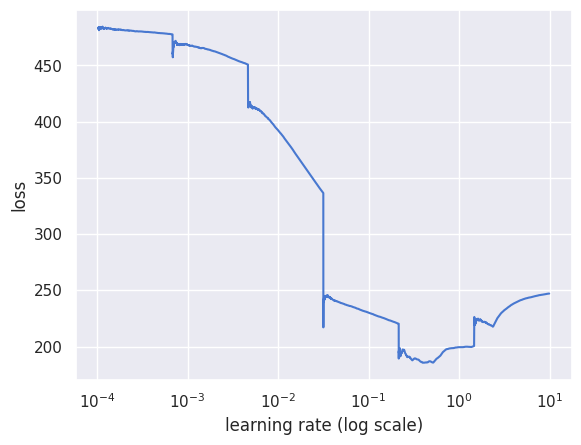

In [ ]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [ ]:
from keras import backend as K
#K.set_value(model.optimizer.learning_rate, 0.3)

batchsize = 18
# fit network
model.fit(X_train, y_train, epochs=20, batch_size=batchsize, verbose=2, shuffle=False)


Epoch 1/20
1790/1790 - 14s - loss: 13.7363 - 14s/epoch - 8ms/step
Epoch 2/20
1790/1790 - 12s - loss: 6.7379 - 12s/epoch - 7ms/step
Epoch 3/20
1790/1790 - 13s - loss: 5.5876 - 13s/epoch - 7ms/step
Epoch 4/20
1790/1790 - 10s - loss: 5.6806 - 10s/epoch - 6ms/step
Epoch 5/20
1790/1790 - 12s - loss: 5.4841 - 12s/epoch - 7ms/step
Epoch 6/20
1790/1790 - 12s - loss: 4.4717 - 12s/epoch - 7ms/step
Epoch 7/20
1790/1790 - 12s - loss: 4.2868 - 12s/epoch - 7ms/step
Epoch 8/20
1790/1790 - 11s - loss: 4.1564 - 11s/epoch - 6ms/step
Epoch 9/20
1790/1790 - 11s - loss: 3.7998 - 11s/epoch - 6ms/step
Epoch 10/20
1790/1790 - 12s - loss: 3.7269 - 12s/epoch - 7ms/step
Epoch 11/20
1790/1790 - 12s - loss: 3.5941 - 12s/epoch - 7ms/step
Epoch 12/20
1790/1790 - 13s - loss: 3.7614 - 13s/epoch - 7ms/step
Epoch 13/20
1790/1790 - 11s - loss: 4.0867 - 11s/epoch - 6ms/step
Epoch 14/20
1790/1790 - 11s - loss: 3.8187 - 11s/epoch - 6ms/step
Epoch 15/20
1790/1790 - 12s - loss: 3.6488 - 12s/epoch - 7ms/step
Epoch 16/20
1790/1

In [ ]:
model.save("lstm_30min", overwrite=True, save_format=None)

In [ ]:
!mv lstm_30min 'drive/MyDrive/jLab Shared Docs/MFC Modeling'

In [ ]:
from keras_lr_finder import LRFinder
# model is a Keras model
lr_finder = LRFinder(model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(X_train, y_train, start_lr=0.0001, end_lr=1, batch_size=512, epochs=5)

Epoch 1/5
1383/1383 [==============================] - 11s 8ms/step - loss: 42.0569
Epoch 2/5
1383/1383 [==============================] - 10s 7ms/step - loss: 38.8623
Epoch 3/5
1383/1383 [==============================] - 10s 8ms/step - loss: 54.7279
Epoch 4/5
1383/1383 [==============================] - 10s 7ms/step - loss: 85.0554
Epoch 5/5
1383/1383 [==============================] - 10s 8ms/step - loss: 87.3932


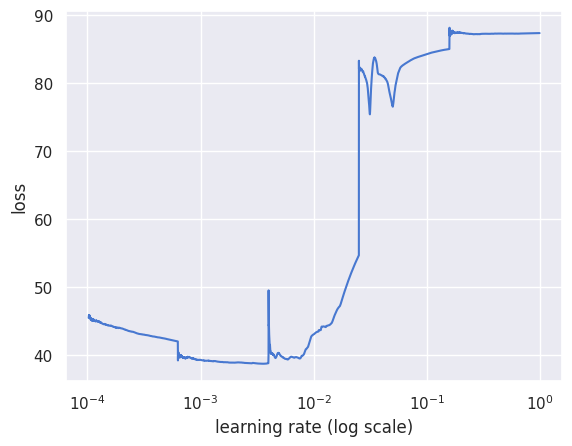

In [ ]:
# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
train_pred = model.predict(X_train, batch_size=batchsize)
test_pred = model.predict(X_test, batch_size=batchsize)

767/767 [==============================] - 2s 3ms/step


In [ ]:
y_train

,power,V1 [10nV],I1L [10pA]
timestamp,,,
2021-06-21 11:25:00-07:00,1540.283104,915.287393,159.515921
2021-06-21 11:30:00-07:00,1565.117849,948.486201,158.836415
2021-06-21 11:35:00-07:00,1566.647996,979.510251,156.328818
2021-06-21 11:40:00-07:00,1592.579653,1002.552448,156.576172
2021-06-21 11:45:00-07:00,1617.058700,1025.352560,157.303444
...,...,...,...
2021-10-13 04:50:00-07:00,470.489637,230.556085,206.539972
2021-10-13 04:55:00-07:00,471.200443,229.796365,207.570490
2021-10-13 05:00:00-07:00,478.045636,228.875178,211.483802


In [ ]:
train_pred

array([[1557.0676 ,  807.3824 ,  200.57466],
       [1597.9078 ,  833.2085 ,  200.88913],
       [1627.1256 ,  860.84753,  198.61047],
       ...,
       [ 313.5142 ,  126.28793,  252.2515 ],
       [ 314.39487,  125.72848,  253.92555],
       [ 310.0657 ,  125.75152,  250.75188]], dtype=float32)

In [ ]:
#Evaluate SMAPE
#print("Train SMAPE:\n", SMAPE(y_train.values.ravel(), train_pred))
#print("Test SMAPE:\n", SMAPE(y_test.values.ravel(), test_pred))

#Evaluate MAPE
print("Train MAPE power:\n", MAPE(y_train['power'].values.ravel(), train_pred[:, 0]))
print("Test MAPE power:\n", MAPE(y_test['power'].values.ravel(), test_pred[:, 0]))

#print("Train MAPE power:\n", MAPE(y_train['power'].shift(1).dropna().values.ravel(), train_pred[:, 0][1:]))
#print("Test MAPE power:\n", MAPE(y_test['power'].shift(1).dropna().values.ravel(), test_pred[:, 0][1:]))

#Evalaute MAE
print("Train MAE power:\n", mean_absolute_error(y_train['power'].values.ravel(), train_pred[:, 0]))
print("Test MAE power:\n", mean_absolute_error(y_test['power'].values.ravel(), test_pred[:, 0]))

Train MAPE power:
 0.07310535168171575
Test MAPE power:
 0.03151058003269545
Train MAE power:
 16.074362103258714
Test MAE power:
 10.343853284840598


In [ ]:
#Evaluate MAPE
print("Train MAPE voltage:\n", MAPE(y_train['V1 [10nV]'].values.ravel(), train_pred[:, 1]))
print("Test MAPE voltage:\n", MAPE(y_test['V1 [10nV]'].values.ravel(), test_pred[:, 1]))

#print("Train MAPE voltage:\n", MAPE(y_train['V1 [10nV]'].shift(1).dropna().values.ravel(), train_pred[:, 1][1:]))
#print("Test MAPE voltage:\n", MAPE(y_test['V1 [10nV]'].shift(1).dropna().values.ravel(), test_pred[:, 1][1:]))

#Evalaute MAE
print("Train MAE voltage:\n", mean_absolute_error(y_train['V1 [10nV]'].values.ravel(), train_pred[:, 1]))
print("Test MAE voltage:\n", mean_absolute_error(y_test['V1 [10nV]'].values.ravel(), test_pred[:, 1]))

Train MAPE voltage:
 0.09446817219925689
Test MAPE voltage:
 0.025745226078289205
Train MAE voltage:
 17.834614439826023
Test MAE voltage:
 3.5772881017513383


In [ ]:
#Evaluate MAPE
print("Train MAPE current:\n", MAPE(y_train['I1L [10pA]'].values.ravel(), train_pred[:, 2]))
print("Test MAPE current:\n", MAPE(y_test['I1L [10pA]'].values.ravel(), test_pred[:, 2]))

#print("Train MAPE current:\n", MAPE(y_train['I1L [10pA]'].shift(1).dropna().values.ravel(), train_pred[:, 2][1:]))
#print("Test MAPE current:\n", MAPE(y_test['I1L [10pA]'].shift(1).dropna().values.ravel(), test_pred[:, 2][1:]))

#Evalaute MAE
print("Train MAE current:\n", mean_absolute_error(y_train['I1L [10pA]'].values.ravel(), train_pred[:, 2]))
print("Test MAE current:\n", mean_absolute_error(y_test['I1L [10pA]'].values.ravel(), test_pred[:, 2]))

Train MAPE current:
 0.09041711859661823
Test MAPE current:
 0.03340263746914974
Train MAE current:
 18.108346392031287
Test MAE current:
 7.844949017430223


In [ ]:
y_train['I1L [10pA]'].diff().min()

-192.79895000000002

In [ ]:
y_train['V1 [10nV]'].diff().min()

-647.5048632575757

In [ ]:
y_train['power'].diff().min()

-948.89687981835

In [ ]:
predictions = model.predict(np.concatenate((X_train, X_test)))

120/120 [==============================] - 0s 2ms/step


In [ ]:
mv1 = df
mv1["power_pred"] = predictions[:, 0]
mv1["voltage_pred"] = predictions[:, 1]
mv1["current_pred"] = predictions[:, 2]
mv1 = mv1.loc[(mv1.index > '2021-12-12') & (mv1.index < '2021-12-14')]
mv2 = mv1

<ipython-input-127-e78f9a62da96>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv1["power_pred"] = predictions[:, 0]
<ipython-input-127-e78f9a62da96>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mv1["voltage_pred"] = predictions[:, 1]
<ipython-input-127-e78f9a62da96>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

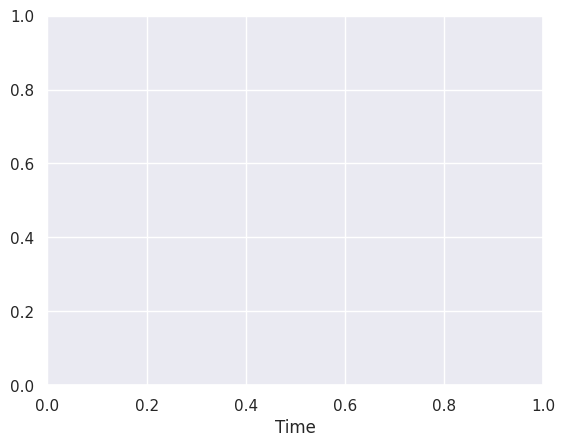

In [ ]:
import matplotlib as mpl
mpl.use('Agg')
#mpl.rc('font', **font)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as md
import datetime
import numpy as np
from pytz import timezone
import pandas as pd
import arrow
import os
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
%matplotlib inline

# Limits for graphs
VOLTAGE_LIM = 0.2
CURRENT_LIM = 40
POWER_LIM = 4




plt.close()
plt.xlabel("Time")
fig, (ax1, ax3) = plt.subplots(2,figsize=(4,2), sharex=True)
fig.autofmt_xdate()


volt_color= 'tab:blue'

amp_color = 'tab:red'


volt_color1= 'tab:blue'
volt_style1 = 'dashed'
volt_color2= 'tab:green'
volt_style2 = 'dotted'
amp_color1 = 'tab:red'
amp_style1='dashed'
amp_color2 = 'tab:orange'
amp_style2='dashdot'


ax3.fmt_xdata = md.DateFormatter('%m-%d')
ax3.xaxis.set_major_formatter(md.DateFormatter('%m-%d'))
#ax3.set_ylabel("Power (uW)")
ax3.set_ylabel("Current")
ax3.grid(True)
#print('max power: ',max(max(1E6*df['power1']),max(1E6*df['power2'])))
#ax3.set_ylim(0, 4)
ax3.plot(mv1.index, 1E6*mv2["current_pred"], color=volt_color1, ls = volt_style1)
ax3.plot(mv1.index, 1E6*mv2['I1L [10pA]'], color=volt_color2, ls = volt_style2)
ax3.legend(['predictions','actual'], loc='upper right', prop={'size': 6})

#Plot error
#ax3.plot(mv1['timestamp'], mv1['error']/mv1['power'], color=volt_color2, ls = volt_style2)
#ax3.legend(['error'], loc='upper right', prop={'size': 6})

ax3.tick_params(axis='x', labelsize=6, rotation=0)
#ax3.xaxis.set_major_locator(plt.MaxNLocator(6))
#ax3.set_xlim(mv.index[0], datetime.date(2020,5,19))
for label in ax3.get_xticklabels():
    label.set_horizontalalignment('center')

plt.tight_layout(pad=0.6, w_pad=0.5, h_pad=0.6)
plt.subplots_adjust(hspace=0.15)
plt.savefig('twobat.pdf')
plt.close()
#tot_energy = np.trapz(df['power1'])
#tot_energy = np.trapz(df['power2'])
#print(tot_energy)